In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from PIL import Image
from sklearn.cluster import KMeans

In [2]:
def RGBtoOPP(img):
  to =  np.array( [ [1/np.sqrt(3),1/np.sqrt(2),1/np.sqrt(6)], 
                    [1/np.sqrt(3), -1/np.sqrt(2), 1/np.sqrt(6)],
                    [1/np.sqrt(3),0,-2/np.sqrt(6)] ] )
  orgb = np.zeros_like(img).astype(np.float32)
  invto = to.T
  i=0
  for row in invto:
    orgb[:,:,i]=row[0]*img[:,:,0]+row[1]*img[:,:,1]+row[2]*img[:,:,2]
    i+=1
  return orgb

In [3]:
def OPPtoRGB(img):
  to =  np.array( [ [1/np.sqrt(3),1/np.sqrt(2),1/np.sqrt(6)], 
                    [1/np.sqrt(3), -1/np.sqrt(2), 1/np.sqrt(6)],
                    [1/np.sqrt(3),0,-2/np.sqrt(6)] ] )
  rgb = np.zeros_like(img).astype(np.float32)
  i=0
  for row in to:
    rgb[:,:,i]=row[0]*img[:,:,0]+row[1]*img[:,:,1]+row[2]*img[:,:,2]
    i+=1
  return rgb

In [4]:
def gaussian_kernel(u,sigma):
	gaussian_kernel_1d_1 = np.expand_dims(signal.gaussian(u.shape[0],sigma),axis=1)
	gaussian_kernel_1d_2 = np.expand_dims(signal.gaussian(u.shape[1],sigma),axis=1)
	gaussian_kernel_2d = np.matmul(gaussian_kernel_1d_1,np.transpose(gaussian_kernel_1d_2))
	gaussian_kernel_2d = gaussian_kernel_2d/np.sum(gaussian_kernel_2d)
	return gaussian_kernel_2d

We donote FFT (Fast Fourier Transform) as $\mathcal{F}$.

We have that 
$$ E(u) = \int_{\Omega} \frac{1}{2}||u(x) - u_0(x)||^2 + \frac{\gamma}{4}\int_{\Omega}\int_{\Omega} w(x-y)||u(x)-u(y)||^2 dxdy.$$
We know previously that
$$ \nabla E(u) = u-u_0 - \gamma(u - w * u).$$
Solving the next equation
$$\nabla E(u) = 0.$$
By linearity and the principal property that link FFT and the product, we have the following equivalent statements:
\begin{eqnarray*}
     u - u_0 - \gamma(u - w_\sigma \ast u) & = & 0 \\
     \mathcal{F}(u - u_0 - \gamma(u - w_\sigma \ast u)) & = & \mathcal{F}(0)\\
     \mathcal{F}(u - u_0 - \gamma(u - \mathcal{F}^{-1}(\mathcal{F}(w_\sigma) \times \mathcal{F}(u))) & = & \mathcal{F} (0) \\
   \mathcal{F}  ( (1-\gamma)u - u_0  +\gamma \mathcal{F}^{-1}(\mathcal{F}(w_\sigma) \times \mathcal{F}(u))) & = & \widehat{0} \\
     (1-\gamma)\mathcal{F}(u) - \mathcal{F}(u_0)  +\gamma \mathcal{F}(w_\sigma) \times \mathcal{F}(u) & = & 0 \\
      (1-\gamma + \gamma \mathcal{F}(w_\sigma))\mathcal{F}(u)  & = & \mathcal{F}(u_0)  \\
      \mathcal{F}(u)  & = & \frac{\mathcal{F}(u_0)}{1-\gamma + \gamma \mathcal{F}(w_\sigma)} \\
      u  & = & \mathcal{F}^{-1}\left(\frac{\widehat{u_0}}{1-\gamma + \gamma \widehat{w_\sigma}}\right) \\
\end{eqnarray*}
Concluding that $ u =  \mathcal{F}^{-1}\left(\frac{\widehat{u_0}}{1-\gamma + \gamma \widehat{w_\sigma}}\right)$ is an expression of the minimum of the functional E, when $\gamma$ is too high, where $w$ is a normalized Gaussian kernel of standard deviation σ.

In [5]:
def imgEnhancement(img,gamma,sigma):
    #  FFT a Gaussiana and shifting
    fwsgm0 = np.fft.fft2(np.fft.fftshift(gaussian_kernel(img,sigma[0])))
    fwsgm1 = np.fft.fft2(np.fft.fftshift(gaussian_kernel(img,sigma[1])))
    fwsgm2 = np.fft.fft2(np.fft.fftshift(gaussian_kernel(img,sigma[1])))
   
    #Details enhancement model
    sgnal0 = np.fft.fft2(img[:,:,0]) / ( 1 - gamma[0] + gamma[0]*fwsgm0)
    #Global contrast enhancement model
    sgnal1 = np.fft.fft2(img[:,:,1]) / ( 1 - gamma[1] + gamma[1]*fwsgm1)
    sgnal2 = np.fft.fft2(img[:,:,2]) / ( 1 - gamma[1] + gamma[1]*fwsgm2)

    # IFFT
    iftsgnal0 = np.fft.ifft2(sgnal0)
    iftsgnal1 = np.fft.ifft2(sgnal1)
    iftsgnal2 = np.fft.ifft2(sgnal2)

    proc_img = np.zeros_like(img).astype(np.float32)
    proc_img[:,:,0] = np.real(iftsgnal0)
    proc_img[:,:,1] = np.real(iftsgnal1)
    proc_img[:,:,2] = np.real(iftsgnal2)

    return proc_img

In [7]:
img4 = Image.open("img4.png")
img4 = np.array(img4).astype(np.uint8)
orgb = RGBtoOPP(img4)

In [8]:
gamma = [0.5,0.75]
sigma = [5,300]
imgproc = imgEnhancement(orgb,gamma,sigma)
rgb = OPPtoRGB(imgproc)

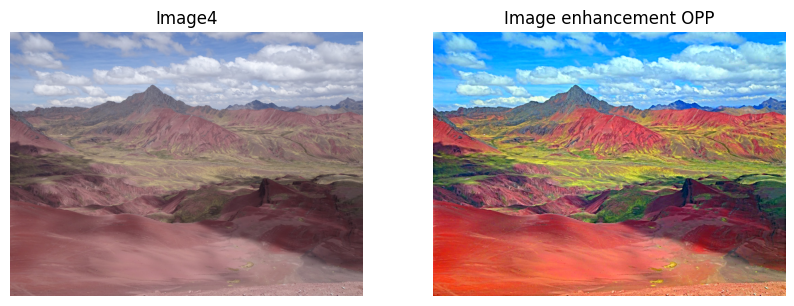

In [9]:
rgb = np.clip(rgb, 0, 255).astype(np.uint8)
figure(figsize=(10,10), dpi=100)
plt.subplot(121), plt.imshow(img4), plt.title('Image4')
plt.axis('off')
plt.subplot(122), plt.imshow(rgb), plt.title('Image enhancement OPP')
plt.axis('off')
plt.show()